In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass
from torch.distributions import MultivariateNormal, Categorical
set_seed(0)



0

In [2]:
class MO2G:
    def __init__(self):
        self.means = torch.tensor(
            [
                [-3.0,1],
                [3, -1],

            ]
        )
        self.covariances = torch.tensor(
            [
                [[1.0, 0], [0, 1.0]],
                [[1.0, 0], [0, 1.0]]

            ]
        )
        self.weights = torch.tensor([0.2,0.8])

        # Create a list of 2D Gaussian distributions
        self.gaussians = [
            MultivariateNormal(mean, covariance)
            for mean, covariance in zip(self.means, self.covariances)
        ]

    def sample(self, sample_shape):
        if isinstance(sample_shape, int):
            sample_shape = (sample_shape,)
        # Sample from the mixture
        categorical = Categorical(self.weights)
        sample_indices = categorical.sample(sample_shape)
        return torch.stack([self.gaussians[i].sample() for i in sample_indices])

    def log_prob(self, input):
        probs = torch.stack([g.log_prob(input).exp() for g in self.gaussians])
        probs = probs.T * self.weights
        return torch.sum(probs, dim=1).log()



In [3]:
#Base distribution
from torch.distributions.multivariate_normal import MultivariateNormal
toy_data = get_distribution("toy_2d")
MOG = toy_data()
MOG = MO2G()
num_samples = 5000
n_iters = 2000
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)

/tmp/ipykernel_351924/2246681964.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


In [4]:
plt.style.use("../../matplotlibrc")


In [5]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.dim = dim
        self.mean = nn.Parameter(torch.randn(dim))
        self.scale_tril = nn.Parameter(torch.eye(dim))
        self.G = torch.distributions.MultivariateNormal(self.mean, scale_tril=self.scale_tril)

    def sample(self,size):
        with torch.no_grad():
            self.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G._unbroadcasted_scale_tril))
        return self.G.rsample((size,))

    def cov(self):
        with torch.no_grad():
            self.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G._unbroadcasted_scale_tril))
        return self.G.covariance_matrix.detach()

    def log_prob(self, value):
        with torch.no_grad():
            self.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G._unbroadcasted_scale_tril))
        return self.G.log_prob(value)

In [6]:
class MOGOpt(nn.Module):
    """The model to optimise"""
    def __init__(self,dim):
        super(MOGOpt, self).__init__()
        self.G1 = Gauss(dim)
        self.G2 = Gauss(dim)
        self.weights = nn.Parameter(torch.tensor([0.5, 0.5]), requires_grad=False)
        self.categorical = Categorical(self.weights)
        self.dim = dim

    def sample(self,size):
        with torch.no_grad():
            self.G1.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G1.G._unbroadcasted_scale_tril))
            self.G2.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G2.G._unbroadcasted_scale_tril))
        samples = torch.zeros(size,self.dim)
        inds= self.categorical.sample((size,))
        s1=self.G1.G.rsample((sum(inds==0),))
        s2=self.G2.G.rsample((sum(inds==1),))
        samples[inds==0]=s1
        samples[inds==1]=s2
        return samples

    def cov(self):
        with torch.no_grad():
            self.G1.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G1.G._unbroadcasted_scale_tril))
            self.G2.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G2.G._unbroadcasted_scale_tril))
        return [self.G1.covariance_matrix.detach(),self.G2.covariance_matrix.detach()]

    def log_prob(self, input, labels=None):
        with torch.no_grad():
            self.G1.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G1.G._unbroadcasted_scale_tril))
            self.G2.G._unbroadcasted_scale_tril.data.copy_(torch.tril(self.G2.G._unbroadcasted_scale_tril))
        probs = torch.stack([self.G1.log_prob(input).exp(),self.G2.log_prob(input).exp()])
        probs = probs.T * self.weights
        return torch.sum(probs, dim=1).log()

    @torch.no_grad
    def e_step(self, input, update_weights=False):
        prob_1 = self.G1.log_prob(input).exp() * self.weights[0]
        prob_2 = self.G2.log_prob(input).exp() * self.weights[1]
        probs = torch.stack([prob_1, prob_2], dim=-1)
        #print(np.shape(probs))
        probs /= probs.sum(dim=-1, keepdim=True)
        randfloat = torch.rand(probs.shape[0])
        clusters = randfloat > probs[:, 0]
        if update_weights:
            #weights = torch.tensor([clusters.numel() - clusters.sum(), clusters.sum()]).to(input.dtype)
            #weights /= weights.sum()
            weights = torch.mean(probs, dim=0)
            self.weights.data.copy_(weights)
        return clusters

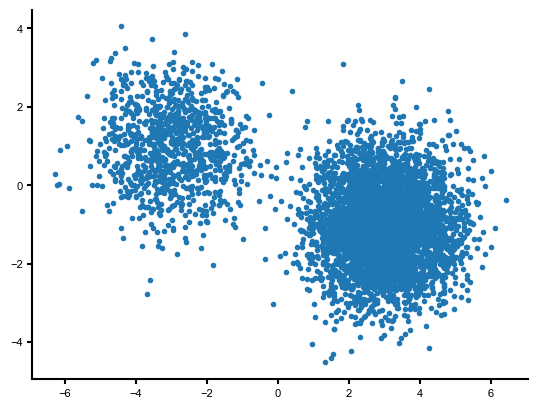

In [7]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")
covar = torch.cov(mixture_samples.T)
#plt.gca().set_box_aspect(1)


#make axis square

#plt.xlim()

In [8]:
def c2st_target(samples1, samples2, density1, density2):
    r"""Computes optimal C2ST and resulting classification cross-entropy loss
    for optimization
    """
    density_ratios1 = torch.stack([density1.log_prob(samples1), density2.log_prob(samples1)], dim=-1)
    density_ratios2 = torch.stack([density1.log_prob(samples2), density2.log_prob(samples2)], dim=-1)
    probs = torch.cat([density_ratios1, density_ratios2], dim=0)
    labels = torch.cat([torch.zeros(len(samples1)), torch.ones(len(samples2))], dim=0).long()
    loss = -nn.functional.cross_entropy(probs, labels)
    with torch.no_grad():
        c2st = (sum(density_ratios1[:, 0] >= density_ratios1[:, 1]) + sum(density_ratios2[:, 0] < density_ratios2[:, 1])) / (len(samples1) + len(samples2))
    return loss, c2st

In [9]:
MOG_model_C2ST = MOGOpt(2)
optimizer= torch.optim.Adam(MOG_model_C2ST.parameters(), lr=1e-2)

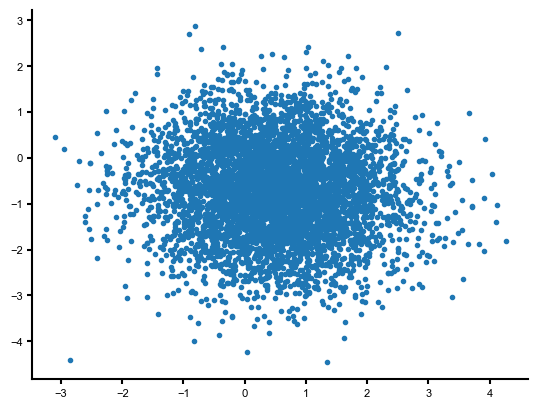

In [10]:
C2ST_samples = MOG_model_C2ST.sample(num_samples).detach().numpy()
plt.scatter(C2ST_samples[:, 0], C2ST_samples[:, 1])


In [11]:

for epoch in range(n_iters):
    optimizer.zero_grad()

    toy_samples = MOG.sample(num_samples)
    toy_clusters = MOG_model_C2ST.e_step(toy_samples, update_weights=True)

    loss = 0.
    c2st = 0.
    for cluster_idx in range(2):
        toy_mask = toy_clusters == cluster_idx
        toy_cluster_samples = toy_samples[toy_mask]
        toy_n_samples = toy_mask.sum()
        if cluster_idx == 0:
            model = MOG_model_C2ST.G1
        elif cluster_idx == 1:
            model = MOG_model_C2ST.G2
        model_cluster_samples = model.sample(toy_n_samples)
        cent_loss, true_c2st = c2st_target(model_cluster_samples, toy_cluster_samples, model, MOG.gaussians[cluster_idx])
        loss += cent_loss# * (toy_n_samples / toy_clusters.numel())
        c2st += true_c2st# * (toy_n_samples / toy_clusters.numel())

    # c2st_loss = torch.mean(torch.square(preds - 0.5))
    if epoch % 5 == 0:
        print("Iter: {}     loss: {}     c2st: {}".format(epoch, cent_loss.item(), true_c2st.item()))
    loss.backward()
    optimizer.step()

Iter: 0     loss: -0.3975297510623932     c2st: 0.8753846287727356


Iter: 5     loss: -0.7656011581420898     c2st: 0.8285066485404968
Iter: 10     loss: -0.9548332095146179     c2st: 0.8083932995796204
Iter: 15     loss: -1.1980009078979492     c2st: 0.7830320000648499
Iter: 20     loss: -1.4278385639190674     c2st: 0.7688498497009277
Iter: 25     loss: -1.662813425064087     c2st: 0.7508532404899597
Iter: 30     loss: -1.8849613666534424     c2st: 0.7398634552955627
Iter: 35     loss: -1.8672351837158203     c2st: 0.7389182448387146
Iter: 40     loss: -1.9695141315460205     c2st: 0.7310323715209961
Iter: 45     loss: -1.9434784650802612     c2st: 0.7355130910873413
Iter: 50     loss: -2.039973497390747     c2st: 0.7263506650924683
Iter: 55     loss: -2.048271656036377     c2st: 0.7238133549690247
Iter: 60     loss: -2.0365095138549805     c2st: 0.7261618375778198
Iter: 65     loss: -1.9767045974731445     c2st: 0.7296918630599976
Iter: 70     loss: -2.0774786472320557     c2st: 0.7310848832130432
Iter: 75     loss: -2.1415634155273438     c2st: 0.7

In [12]:
MOG_model_C2ST.weights

Parameter containing:
tensor([0.8016, 0.1984])

In [13]:
MOG_model_C2ST.G2.mean

Parameter containing:
tensor([-3.0000,  0.9731], requires_grad=True)

In [14]:
MOG_model_C2ST.G1.mean

Parameter containing:
tensor([ 3.0006, -0.9961], requires_grad=True)

In [15]:
# MMD
MOG_model_MMD = MOGOpt(dim=2)
with torch.no_grad():
    samples = MOG_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)


bandwidth:  tensor(2.2806)


In [16]:

bandwidth = 1
optimizer = torch.optim.Adam(MOG_model_MMD.parameters(), lr=0.01)
MOG_model_MMD.train()

for epoch in range(n_iters):
    optimizer.zero_grad()

    toy_samples = MOG.sample(num_samples)
    toy_clusters = MOG_model_MMD.e_step(toy_samples, update_weights=True)

    loss = 0.
    c2st = 0.
    for cluster_idx in range(2):
        toy_mask = toy_clusters == cluster_idx
        toy_cluster_samples = toy_samples[toy_mask]
        toy_n_samples = toy_mask.sum()
        if cluster_idx == 0:
            model = MOG_model_MMD.G1
        elif cluster_idx == 1:
            model = MOG_model_MMD.G2
        model_cluster_samples = model.sample(toy_n_samples)
        cent_loss= compute_rbf_mmd(model_cluster_samples, toy_cluster_samples, bandwidth)
        loss += cent_loss# * (toy_n_samples / toy_clusters.numel())

    # c2st_loss = torch.mean(torch.square(preds - 0.5))
    if epoch % 1== 0:
        print("Iter: {}     loss: {}     ".format(epoch, cent_loss.item()))
    loss.backward()
    optimizer.step()
MOG_model_MMD.eval()



Iter: 0     loss: 0.34339043498039246     
Iter: 1     loss: 0.3629820644855499     
Iter: 2     loss: 0.36914193630218506     
Iter: 3     loss: 0.3442980647087097     
Iter: 4     loss: 0.3471361994743347     
Iter: 5     loss: 0.3390767574310303     
Iter: 6     loss: 0.33874011039733887     
Iter: 7     loss: 0.3598696291446686     
Iter: 8     loss: 0.32394468784332275     
Iter: 9     loss: 0.3142017722129822     
Iter: 10     loss: 0.3104874789714813     
Iter: 11     loss: 0.3158491253852844     
Iter: 12     loss: 0.293809711933136     
Iter: 13     loss: 0.2852667272090912     
Iter: 14     loss: 0.2791976034641266     
Iter: 15     loss: 0.2771603763103485     
Iter: 16     loss: 0.27349787950515747     
Iter: 17     loss: 0.27806204557418823     
Iter: 18     loss: 0.2699427604675293     
Iter: 19     loss: 0.28680986166000366     
Iter: 20     loss: 0.26300203800201416     
Iter: 21     loss: 0.23288145661354065     
Iter: 22     loss: 0.24270525574684143     
Iter: 23    

MOGOpt(
  (G1): Gauss()
  (G2): Gauss()
)

In [17]:
# WS

MOG_model_WS = MOGOpt(dim=2)
optimizer = torch.optim.Adam(MOG_model_WS.parameters(), lr=0.01)
MOG_model_WS.train()

for epoch in range(n_iters):
    optimizer.zero_grad()

    toy_samples = MOG.sample(num_samples)
    toy_clusters = MOG_model_WS.e_step(toy_samples, update_weights=True)

    loss = 0.
    c2st = 0.
    for cluster_idx in range(2):
        toy_mask = toy_clusters == cluster_idx
        toy_cluster_samples = toy_samples[toy_mask]
        toy_n_samples = toy_mask.sum()
        if cluster_idx == 0:
            model = MOG_model_WS.G1
        elif cluster_idx == 1:
            model = MOG_model_WS.G2
        model_cluster_samples = model.sample(toy_n_samples)
        cent_loss= sliced_wasserstein_distance(model_cluster_samples,toy_cluster_samples)#, bandwidth=bandwidth)
        loss += cent_loss# * (toy_n_samples / toy_clusters.numel())

    # c2st_loss = torch.mean(torch.square(preds - 0.5))
    if epoch % 1== 0:
        print("Iter: {}     loss: {}     ".format(epoch, cent_loss.item()))
    loss.backward()
    optimizer.step()
MOG_model_WS.eval()



Iter: 0     loss: 0.5445838570594788     
Iter: 1     loss: 0.5720165371894836     
Iter: 2     loss: 0.5230281352996826     
Iter: 3     loss: 0.5067282319068909     
Iter: 4     loss: 0.5729857087135315     
Iter: 5     loss: 0.5132997632026672     
Iter: 6     loss: 0.5302207469940186     
Iter: 7     loss: 0.47876954078674316     
Iter: 8     loss: 0.5101834535598755     
Iter: 9     loss: 0.484764963388443     
Iter: 10     loss: 0.46862006187438965     
Iter: 11     loss: 0.45757749676704407     
Iter: 12     loss: 0.43430644273757935     
Iter: 13     loss: 0.4486140012741089     
Iter: 14     loss: 0.4325873851776123     
Iter: 15     loss: 0.41836854815483093     
Iter: 16     loss: 0.4331638813018799     
Iter: 17     loss: 0.412354975938797     
Iter: 18     loss: 0.38930410146713257     
Iter: 19     loss: 0.3898368179798126     
Iter: 20     loss: 0.33276790380477905     
Iter: 21     loss: 0.3961324989795685     
Iter: 22     loss: 0.3701673150062561     
Iter: 23     los

Iter: 43     loss: 0.20685766637325287     
Iter: 44     loss: 0.15390099585056305     
Iter: 45     loss: 0.1588730812072754     
Iter: 46     loss: 0.16166642308235168     
Iter: 47     loss: 0.14255434274673462     
Iter: 48     loss: 0.13776107132434845     
Iter: 49     loss: 0.11156553030014038     
Iter: 50     loss: 0.09700614213943481     
Iter: 51     loss: 0.09855987131595612     
Iter: 52     loss: 0.09259360283613205     
Iter: 53     loss: 0.11017625033855438     
Iter: 54     loss: 0.07940042018890381     
Iter: 55     loss: 0.0801992192864418     
Iter: 56     loss: 0.08089637756347656     
Iter: 57     loss: 0.07089046388864517     
Iter: 58     loss: 0.05476832389831543     
Iter: 59     loss: 0.04907236993312836     
Iter: 60     loss: 0.040399689227342606     
Iter: 61     loss: 0.06415629386901855     
Iter: 62     loss: 0.056352872401475906     
Iter: 63     loss: 0.052515555173158646     
Iter: 64     loss: 0.05742929130792618     
Iter: 65     loss: 0.0544531717

MOGOpt(
  (G1): Gauss()
  (G2): Gauss()
)

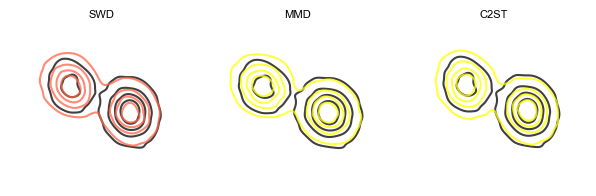

In [18]:
SWD_samples = MOG_model_WS.sample(num_samples).detach().numpy()
MMD_samples = MOG_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = MOG_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': C2ST_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (6,2))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)

sns.kdeplot(ax=axs[0],data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=MMD_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=C2ST_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title("SWD")
axs[1].set_title("MMD")
axs[2].set_title("C2ST")

fig.tight_layout()


In [19]:
#FROM: https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=[1,2], ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    for std in nstd:
    # Width and height are "full" widths, not radius
        width, height = 2 * std * np.sqrt(vals)
        print(pos,width, height,theta)
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

        ax.add_artist(ellip)
    return ellip

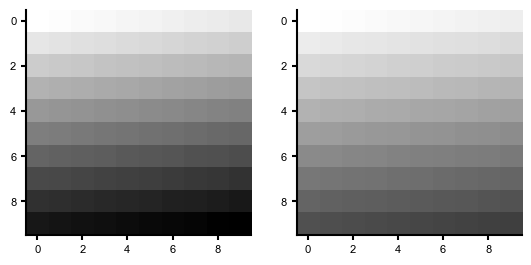

In [20]:
# FROM: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
import matplotlib.colors as colors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_yarg')
new_cmap = truncate_colormap(cmap, 0, 0.75)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

[-3.0122519   0.98729837] 0.22142105 0.21811494 177.4518
[-3.0122519   0.98729837] 0.6642631 0.6543448 177.4518
[-3.0122519   0.98729837] 1.3285263 1.3086896 177.4518
[-3.0122519   0.98729837] 2.2142105 2.1811495 177.4518
[ 2.9945474 -1.0017607] 0.44878063 0.4447796 -158.14038
[ 2.9945474 -1.0017607] 1.3463418 1.3343388 -158.14038
[ 2.9945474 -1.0017607] 2.6926837 2.6686776 -158.14038
[ 2.9945474 -1.0017607] 4.4878063 4.447796 -158.14038
[ 3.0005884  -0.99614424] 0.4484553 0.44373176 -165.67686
[ 3.0005884  -0.99614424] 1.3453659 1.3311952 -165.67686
[ 3.0005884  -0.99614424] 2.6907318 2.6623905 -165.67686
[ 3.0005884  -0.99614424] 4.484553 4.4373174 -165.67686
[ 2.9931438 -1.0057479] 0.4586225 0.445943 -156.65286
[ 2.9931438 -1.0057479] 1.3758675 1.337829 -156.65286
[ 2.9931438 -1.0057479] 2.751735 2.675658 -156.65286
[ 2.9931438 -1.0057479] 4.586225 4.4594297 -156.65286
[-3.0143282  1.017098 ] 0.22435932 0.21998322 138.55507
[-3.0143282  1.017098 ] 0.67307794 0.65994966 138.55507
[-3

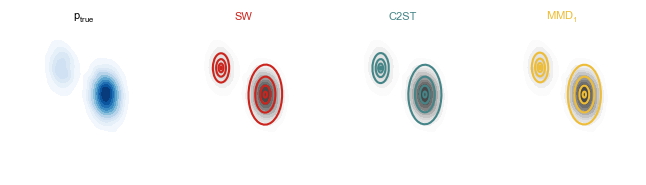

In [22]:
num_samples = 10000
#SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
#MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
#C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
#SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
#MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
#C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,4, figsize = (6.5,3))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y',cmap="Blues", fill=True,levels=12)#, thresh=.1,)#, color="black",alpha=0.75, levels=5)

alpha_bg=1
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[3],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)

#x, y = np.mgrid[-10:10:.1, -10:10:.1]
#z =torch.exp(gauss_model_WS.log_prob(data)).detach().numpy()
##axs[1].contour(x, y, z,colors ='#cc241d')#), cmap='coolwarm',fill=False)
##z =torch.exp(gauss_model_MMD.log_prob(data)).detach().numpy()
#axs[2].contour(x, y, z,colors ='#eebd35')#), cmap='coolwarm',fill=False)
#z =torch.exp(gauss_model_C2ST.log_prob(data)).detach().numpy()
#axs[3].contour(x, y, z,colors ="#458588")#), cmap='coolwarm',fill=False)
std_plot = [np.sqrt(.25),np.sqrt(.5),np.sqrt(1),np.sqrt(2)]
std_plot=[.25,.75,1.5,2.5]

plot_cov_ellipse(MOG_model_WS.weights[0].detach().numpy()*MOG_model_WS.G1.cov().detach().numpy(),MOG_model_WS.G1.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[1],edgecolor='#cc241d', lw=1.5, facecolor='none')
plot_cov_ellipse(MOG_model_MMD.weights[0]*MOG_model_MMD.G1.cov().detach().numpy(),MOG_model_MMD.G1.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[3],edgecolor='#eebd35', lw=1.5, facecolor='none')
plot_cov_ellipse(MOG_model_C2ST.weights[0]*MOG_model_C2ST.G1.cov().detach().numpy(),MOG_model_C2ST.G1.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[2],edgecolor='#458588', lw=1.5, facecolor='none')



plot_cov_ellipse(MOG_model_WS.weights[1].detach().numpy()*MOG_model_WS.G2.cov().detach().numpy(),MOG_model_WS.G2.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[1],edgecolor='#cc241d', lw=1.5, facecolor='none')
plot_cov_ellipse(MOG_model_MMD.weights[1].detach().numpy()*MOG_model_MMD.G2.cov().detach().numpy(),MOG_model_MMD.G2.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[3],edgecolor='#eebd35', lw=1.5, facecolor='none')
plot_cov_ellipse(MOG_model_C2ST.weights[1].detach().numpy()*MOG_model_C2ST.G2.cov().detach().numpy(),MOG_model_C2ST.G2.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[2],edgecolor='#458588', lw=1.5, facecolor='none')


#sns.kdeplot(ax=axs[1],data=SWD_df, x='x', y='y', fill=False,cmap ="Reds",levels=7)#,color="#cc241d",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[2],data=MMD_df, x='x', y='y', fill=False,cmap='Wistia',levels=7)#color="#eebd35",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[3],data=C2ST_df, x='x', y='y', fill=False,cmap='Blues',levels=7)#color="#eebd35",alpha=.5, levels=5)
#color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(-8,5)
    ax.set_xlim(-10,10)

    ax.set_ylim(-7,4)
    #make square subplots 
    ax.set_box_aspect(1)
axs[0].set_title(r"$p_{true}$")
axs[1].set_title("SW",color ='#cc241d')
axs[3].set_title(r"$MMD_1$",color ='#eebd35')
axs[2].set_title("C2ST",color ="#458588")

fig.tight_layout()
plt.savefig("mode.pdf")